# First train a model
This first block of code defines a simple neural network, imaginatively called "model", 784 inputs for 28*28 pixels, then two hidden layers of 128 nodes each, the final layer is 10 outputs giving the probabilty of each class. This model is trained for one epoch (one lap of the training set) and reaches 91.16% test set accuracy, more epochs and layers can be added to improve accuracy. This first block is code from Francois Chollet https://github.com/fchollet that has loads of great examples

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
#model.add(Conv2D(32, kernel_size=(3, 3),
#                 activation='relu',
#                 input_shape=input_shape))
#model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
#model.add(Flatten())
model.add(Flatten(input_shape=input_shape))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 3s - loss: 0.9098 - acc: 0.7044 - val_loss: 0.3067 - val_acc: 0.9116

# The drawing function for inputting one's own writing!
This load packages and defines a function that take a keras model, and opens a drawing canvas, converts a drawing to mnist style and feeds it into the trained model it is given to yield a probabilty distribution.

In [2]:
from tkinter import *
import time
from PIL import Image, ImageDraw
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
def DrawMyOwnNumbers(Kerasmodel):
    white = (255, 255, 255)
    black = (0, 0, 0)

    b1 = "up"
    xold, yold = None, None    

    def b1down(event):
        nonlocal b1
        b1 = "down"           

    def b1up(event):
        nonlocal b1, xold, yold
        b1 = "up"
        xold = None
        yold = None
    def motion(event):
            if b1 == "down":
                nonlocal xold, yold
                if xold is not None and yold is not None:
                    event.widget.create_line(xold,yold,event.x,event.y)
                    draw.line([xold,yold,event.x,event.y], black)
                xold = event.x
                yold = event.y
    root = Tk()
    width=200
    height=200
    drawing_area = Canvas(root,width=width,height=height)
    image1 = Image.new("RGB", (width, height), white)
    draw = ImageDraw.Draw(image1)
    drawing_area.pack()
    drawing_area.bind("<Motion>", motion)
    drawing_area.bind("<ButtonPress-1>", b1down)
    drawing_area.bind("<ButtonRelease-1>", b1up)
    
    def handle_click():
        nonlocal root
        root.destroy()
        %matplotlib inline


        filename = "4my_drawing.bmp"
        image1.save(filename)
        II=np.asarray(mpimg.imread(filename))
        II=np.apply_along_axis(np.min,2,II)
        

        data=[[i,j] for i in range(200) for j in range(200) if II[j,i]==0]
        datax=np.asarray([x for [x,y] in data])
        datay=np.asarray([y for [x,y] in data])
        dx=width/28
        positions = np.linspace(dx/2,width - dx/2, 28)
        def kde(x,y):
            return(np.min([np.sum(np.exp(-0.5*((x-datax)**2+(y-datay)**2)/4**2)),5]))

        positions = np.linspace(dx/2,width - dx/2, 28)
        output=np.asarray([[kde(x,y) for x in positions] for y in positions])
        output=output/output.max()
        output1=np.asarray([[[ [output[j,i]] for i in np.arange(28)] for j in np.arange(28)]])

        p= Kerasmodel.predict_proba(output1,verbose=1==2)[0]
        
        f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))
        ax1.imshow(255-II,cmap='Greys')
        #ax2.imshow(output,cmap='Greys')
        
        def PlotMnist(inn,ax):
            ax.imshow(inn[0,:,:,0],cmap='Greys')
        
        PlotMnist(output1,ax2)
#       PlotMnist(x_test,ax3)        
        ax3.bar(np.arange(10),p,0.8,color='g')


    Button(root, text='classify!', command=handle_click).pack()
    root.mainloop()

# Call the DrawMyOwnNumbers function
WE trained a model at the beginning, lets see if it can recognise our writing. A white box will appear, draw your number and click classify!
Then the code will convert the drawing to Mnist style and put it onto your keras model which will then be used to predict what number the drawing is!

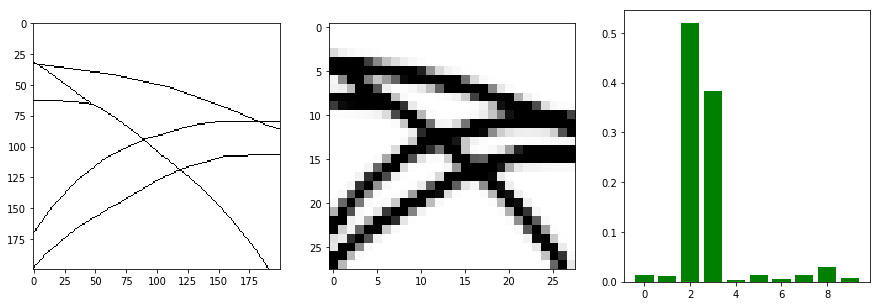

In [4]:
DrawMyOwnNumbers(model)